In [1]:
import torchvision

In [2]:
import os
import json
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
import json

with open('/kaggle/input/ssl-dataset/ssl_dataset/Labels.json', 'r') as f:
    labels_data = json.load(f)

print("Top-level keys:", labels_data.keys())


Top-level keys: dict_keys(['n01968897', 'n01770081', 'n01818515', 'n02011460', 'n01496331', 'n01847000', 'n01687978', 'n01740131', 'n01537544', 'n01491361', 'n02007558', 'n01735189', 'n01630670', 'n01440764', 'n01819313', 'n02002556', 'n01667778', 'n01755581', 'n01924916', 'n01751748', 'n01984695', 'n01729977', 'n01614925', 'n01608432', 'n01443537', 'n01770393', 'n01855672', 'n01560419', 'n01592084', 'n01914609', 'n01582220', 'n01667114', 'n01985128', 'n01820546', 'n01773797', 'n02006656', 'n01986214', 'n01484850', 'n01749939', 'n01828970', 'n02018795', 'n01695060', 'n01729322', 'n01677366', 'n01734418', 'n01843383', 'n01806143', 'n01773549', 'n01775062', 'n01728572', 'n01601694', 'n01978287', 'n01930112', 'n01739381', 'n01883070', 'n01774384', 'n02037110', 'n01795545', 'n02027492', 'n01531178', 'n01944390', 'n01494475', 'n01632458', 'n01698640', 'n01675722', 'n01877812', 'n01622779', 'n01910747', 'n01860187', 'n01796340', 'n01833805', 'n01685808', 'n01756291', 'n01514859', 'n01753488'

In [6]:
#mapping the json file 

In [3]:
with open('/kaggle/input/ssl-dataset/ssl_dataset/Labels.json', 'r') as f:
    labels_map = json.load(f)


In [4]:
selected_classes = list(labels_map.keys())[:40]  # Select first 40 classes


In [9]:
print(list(labels_map.items())[:5])


[('n01968897', 'chambered nautilus, pearly nautilus, nautilus'), ('n01770081', 'harvestman, daddy longlegs, Phalangium opilio'), ('n01818515', 'macaw'), ('n02011460', 'bittern'), ('n01496331', 'electric ray, crampfish, numbfish, torpedo')]


In [5]:
class SSLDataset(Dataset):
    def __init__(self, root_dirs, classes, transform=None):
        self.image_paths = []
        for root_dir in root_dirs:
            for cls in classes:
                cls_dir = os.path.join(root_dir, cls)
                if os.path.isdir(cls_dir):
                    for img_name in os.listdir(cls_dir):
                        img_path = os.path.join(cls_dir, img_name)
                        self.image_paths.append(img_path)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            img1 = self.transform(image)
            img2 = self.transform(image)
        return img1, img2


In [6]:
#data transform
ssl_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [7]:
#dataset and loadeer 

train_dirs = [
    '/kaggle/input/ssl-dataset/ssl_dataset/train.X1',
    '/kaggle/input/ssl-dataset/ssl_dataset/train.X2',
    '/kaggle/input/ssl-dataset/ssl_dataset/train.X3',
    '/kaggle/input/ssl-dataset/ssl_dataset/train.X4'
]

train_dataset = SSLDataset(train_dirs, selected_classes, transform=ssl_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)


In [15]:
#barlowtwins model
class BarlowTwinsModel(nn.Module):
    def __init__(self, projector_dim=8192):
        super(BarlowTwinsModel, self).__init__()
        self.backbone = models.resnet18(weights = None)
        self.backbone.fc = nn.Identity()
        self.projector = nn.Sequential(
            nn.Linear(512, projector_dim),
            nn.BatchNorm1d(projector_dim),
            nn.ReLU(),
            nn.Linear(projector_dim, projector_dim)
        )

    def forward(self, x):
        y = self.backbone(x)
        z = self.projector(y)
        return z


In [16]:
#barlow twin class
class BarlowTwinsLoss(nn.Module):
    def __init__(self, lambda_param=5e-3):
        super(BarlowTwinsLoss, self).__init__()
        self.lambda_param = lambda_param

    def forward(self, z1, z2):
        N, D = z1.size()
        z1_norm = (z1 - z1.mean(0)) / z1.std(0)
        z2_norm = (z2 - z2.mean(0)) / z2.std(0)
        c = torch.mm(z1_norm.T, z2_norm) / N
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = off_diagonal(c).pow_(2).sum()
        loss = on_diag + self.lambda_param * off_diag
        return loss

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


In [17]:
#training loop
model = BarlowTwinsModel().to(device)
criterion = BarlowTwinsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for img1, img2 in tqdm(train_loader):
        img1, img2 = img1.to(device), img2.to(device)
        z1 = model(img1)
        z2 = model(img2)
        loss = criterion(z1, z2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')


100%|██████████| 813/813 [12:16<00:00,  1.10it/s]


Epoch [1/10], Loss: 15025.4396


100%|██████████| 813/813 [09:35<00:00,  1.41it/s]


Epoch [2/10], Loss: 13365.6241


100%|██████████| 813/813 [09:27<00:00,  1.43it/s]


Epoch [3/10], Loss: 13341.6209


100%|██████████| 813/813 [09:32<00:00,  1.42it/s]


Epoch [4/10], Loss: 12911.0330


100%|██████████| 813/813 [09:31<00:00,  1.42it/s]


Epoch [5/10], Loss: 12819.9207


100%|██████████| 813/813 [09:37<00:00,  1.41it/s]


Epoch [6/10], Loss: 12924.6291


100%|██████████| 813/813 [09:36<00:00,  1.41it/s]


Epoch [7/10], Loss: 12895.4021


100%|██████████| 813/813 [09:37<00:00,  1.41it/s]


Epoch [8/10], Loss: 13165.0534


100%|██████████| 813/813 [09:30<00:00,  1.43it/s]


Epoch [9/10], Loss: 12898.7975


100%|██████████| 813/813 [09:32<00:00,  1.42it/s]

Epoch [10/10], Loss: 13092.2558


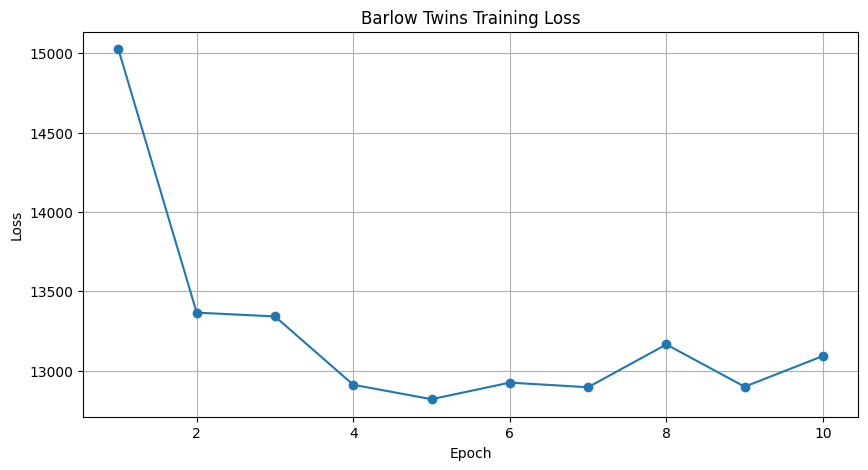

In [18]:
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), losses, marker='o')
plt.title('Barlow Twins Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [45]:
#linear probe

In [37]:
print(f'Validation dataset size: {len(val_dataset)}')


Validation dataset size: 2000


In [38]:
class FeatureExtractor(nn.Module):
    def __init__(self, backbone):
        super(FeatureExtractor, self).__init__()
        self.backbone = backbone
        self.backbone.fc = nn.Identity()

    def forward(self, x):
        return self.backbone(x)


In [40]:
#laballed dataset  
class LabeledDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        for cls in classes:
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    img_path = os.path.join(cls_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[cls])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [34]:
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_dataset = LabeledDataset('/kaggle/input/ssl-dataset/valid', selected_classes, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)


In [41]:
print(f'Validation dataset size: {len(val_dataset)}')


Validation dataset size: 2000


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Extract features
model.eval()
features = []
labels = []
with torch.no_grad():
    for images, lbls in tqdm(val_loader):
        images = images.to(device)
        feats = model.backbone(images)
        features.append(feats.cpu().numpy())
        labels.extend(lbls.numpy())

features = np.concatenate(features, axis=0)
labels = np.array(labels)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(features, labels)

# Predictions
preds = clf.predict(features)

# Evaluation
acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='weighted')

print(f'Linear Probing Accuracy: {acc:.4f}')
print(f'Linear Probing F1 Score: {f1:.4f}')


100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Linear Probing Accuracy: 0.1515
Linear Probing F1 Score: 0.1417


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


100%|██████████| 32/32 [00:08<00:00,  3.60it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probing Accuracy: 0.1515
Linear Probing F1 Score: 0.1417


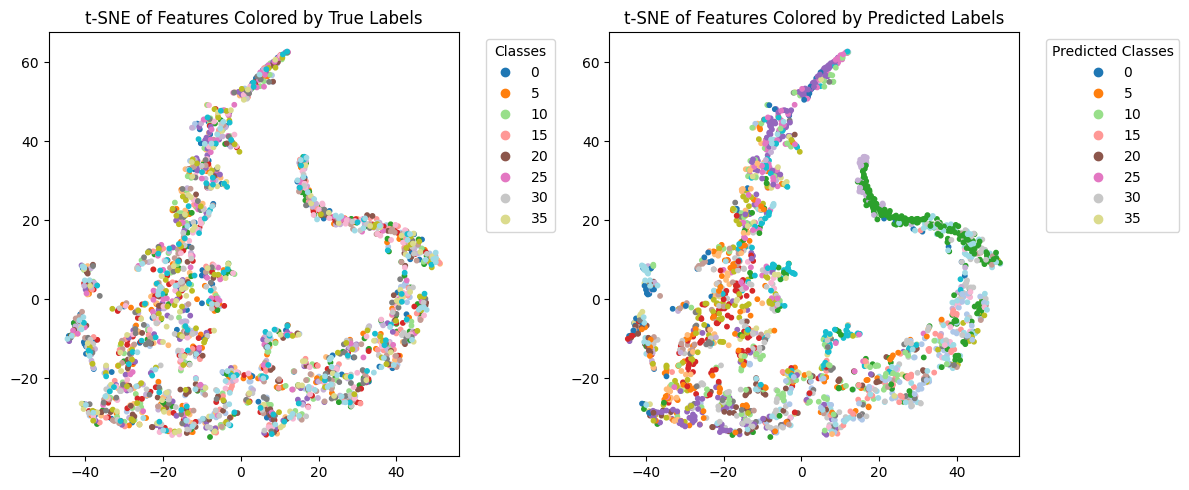

In [48]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from tqdm import tqdm
import torch

# Extract features and labels
model.eval()
features = []
labels = []
with torch.no_grad():
    for images, lbls in tqdm(val_loader):
        images = images.to(device)
        feats = model.backbone(images)
        features.append(feats.cpu().numpy())
        labels.extend(lbls.numpy())

features = np.concatenate(features, axis=0)
labels = np.array(labels)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(features, labels)

# Predictions
preds = clf.predict(features)

# Evaluation
acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='weighted')
print(f'Linear Probing Accuracy: {acc:.4f}')
print(f'Linear Probing F1 Score: {f1:.4f}')

# Dimensionality reduction with t-SNE (2D)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features)

# Plot true labels
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=labels, cmap='tab20', s=10)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('t-SNE of Features Colored by True Labels')

# Plot predicted labels
plt.subplot(1,2,2)
scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=preds, cmap='tab20', s=10)
plt.legend(*scatter.legend_elements(), title="Predicted Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('t-SNE of Features Colored by Predicted Labels')

plt.tight_layout()
plt.show()


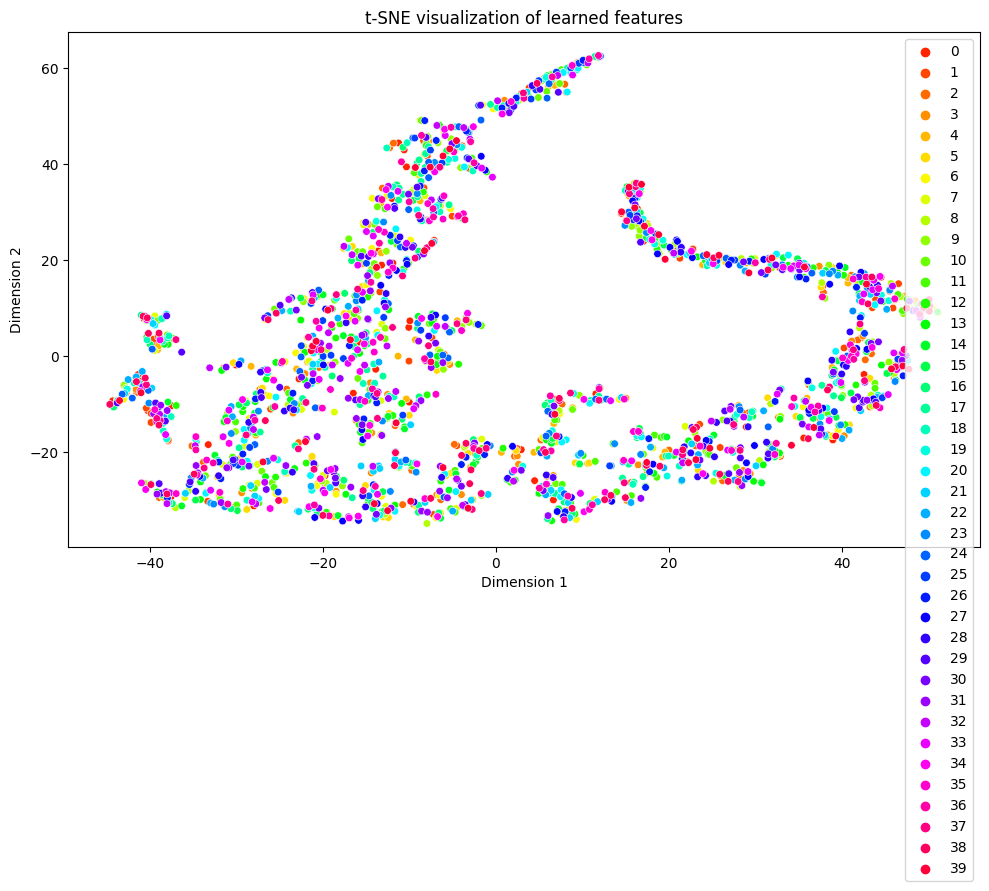

In [47]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce dimensionality for visualization (e.g., to 2D)
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Create a scatter plot
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(np.unique(labels)))
sns.scatterplot(
    x=features_2d[:, 0], y=features_2d[:, 1],
    hue=labels, legend='full', palette=palette, s=30
)
plt.title("t-SNE visualization of learned features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.tight_layout()
plt.show()
